使用到的套件

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

讀檔

In [2]:
df = pd.read_excel ('SECOM.xlsx',sheet_name = 'secom')

### (a) Construct a data science framework and show the data summary
簡單了解資料的分布情形

In [3]:
des = df.describe()

# # of missing value by counting null
count_missing = df.isnull().sum(axis=0)
des = des.append(pd.Series(count_missing, name='# of missing value'))

# # of outlier by value out of (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
count_outlier = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
des= des.append(pd.Series(count_outlier, name='# of outlier'))

In [4]:
pd.set_option('display.max_columns', None)
display(des)

,Unnamed: 0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Sensor_22,Sensor_23,Sensor_24,Sensor_25,Sensor_26,Sensor_27,Sensor_28,Sensor_29,Sensor_30,Sensor_31,Sensor_32,Sensor_33,Sensor_34,Sensor_35,Sensor_36,Sensor_37,Sensor_38,Sensor_39,Sensor_40,Sensor_41,Sensor_42,Sensor_43,Sensor_44,Sensor_45,Sensor_46,Sensor_47,Sensor_48,Sensor_49,Sensor_50,Sensor_51,Sensor_52,Sensor_53,Sensor_54,Sensor_55,Sensor_56,Sensor_57,Sensor_58,Sensor_59,Sensor_60,Sensor_61,Sensor_62,Sensor_63,Sensor_64,Sensor_65,Sensor_66,Sensor_67,Sensor_68,Sensor_69,Sensor_70,Sensor_71,Sensor_72,Sensor_73,Sensor_74,Sensor_75,Sensor_76,Sensor_77,Sensor_78,Sensor_79,Sensor_80,Sensor_81,Sensor_82,Sensor_83,Sensor_84,Sensor_85,Sensor_86,Sensor_87,Sensor_88,Sensor_89,Sensor_90,Sensor_91,Sensor_92,Sensor_93,Sensor_94,Sensor_95,Sensor_96,Sensor_97,Sensor_98,Sensor_99,Sensor_100,Sensor_101,Sensor_102,Sensor_103,Sensor_104,Sensor_105,Sensor_106,Sensor_107,Sensor_108,Sensor_109,Sensor_110,Sensor_111,Sensor_112,Sensor_113,Sensor_114,Sensor_115,Sensor_116,Sensor_117,Sensor_118,Sensor_119,Sensor_120,Sensor_121,Sensor_122,Sensor_123,Sensor_124,Sensor_125,Sensor_126,Sensor_127,Sensor_128,Sensor_129,Sensor_130,Sensor_131,Sensor_132,Sensor_133,Sensor_134,Sensor_135,Sensor_136,Sensor_137,Sensor_138,Sensor_139,Sensor_140,Sensor_141,Sensor_142,Sensor_143,Sensor_144,Sensor_145,Sensor_146,Sensor_147,Sensor_148,Sensor_149,Sensor_150,Sensor_151,Sensor_152,Sensor_153,Sensor_154,Sensor_155,Sensor_156,Sensor_157,Sensor_158,Sensor_159,Sensor_160,Sensor_161,Sensor_162,Sensor_163,Sensor_164,Sensor_165,Sensor_166,Sensor_167,Sensor_168,Sensor_169,Sensor_170,Sensor_171,Sensor_172,Sensor_173,Sensor_174,Sensor_175,Sensor_176,Sensor_177,Sensor_178,Sensor_179,Sensor_180,Sensor_181,Sensor_182,Sensor_183,Sensor_184,Sensor_185,Sensor_186,Sensor_187,Sensor_188,Sensor_189,Sensor_190,Sensor_191,Sensor_192,Sensor_193,Sensor_194,Sensor_195,Sensor_196,Sensor_197,Sensor_198,Sensor_199,Sensor_200,Sensor_201,Sensor_202,Sensor_203,Sensor_204,Sensor_205,Sensor_206,Sensor_207,Sensor_208,Sensor_209,Sensor_210,Sensor_211,Sensor_212,Sensor_213,Sensor_214,Sensor_215,Sensor_216,Sensor_217,Sensor_218,Sensor_219,Sensor_220,Sensor_221,Sensor_222,Sensor_223,Sensor_224,Sensor_225,Sensor_226,Sensor_227,Sensor_228,Sensor_229,Sensor_230,Sensor_231,Sensor_232,Sensor_233,Sensor_234,Sensor_235,Sensor_236,Sensor_237,Sensor_238,Sensor_239,Sensor_240,Sensor_241,Sensor_242,Sensor_243,Sensor_244,Sensor_245,Sensor_246,Sensor_247,Sensor_248,Sensor_249,Sensor_250,Sensor_251,Sensor_252,Sensor_253,Sensor_254,Sensor_255,Sensor_256,Sensor_257,Sensor_258,Sensor_259,Sensor_260,Sensor_261,Sensor_262,Sensor_263,Sensor_264,Sensor_265,Sensor_266,Sensor_267,Sensor_268,Sensor_269,Sensor_270,Sensor_271,Sensor_272,Sensor_273,Sensor_274,Sensor_275,Sensor_276,Sensor_277,Sensor_278,Sensor_279,Sensor_280,Sensor_281,Sensor_282,Sensor_283,Sensor_284,Sensor_285,Sensor_286,Sensor_287,Sensor_288,Sensor_289,Sensor_290,Sensor_291,Sensor_292,Sensor_293,Sensor_294,Sensor_295,Sensor_296,Sensor_297,Sensor_298,Sensor_299,Sensor_300,Sensor_301,Sensor_302,Sensor_303,Sensor_304,Sensor_305,Sensor_306,Sensor_307,Sensor_308,Sensor_309,Sensor_310,Sensor_311,Sensor_312,Sensor_313,Sensor_314,Sensor_315,Sensor_316,Sensor_317,Sensor_318,Sensor_319,Sensor_320,Sensor_321,Sensor_322,Sensor_323,Sensor_324,Sensor_325,Sensor_326,Sensor_327,Sensor_328,Sensor_329,Sensor_330,Sensor_331,Sensor_332,Sensor_333,Sensor_334,Sensor_335,Sensor_336,Sensor_337,Sensor_338,Sensor_339,Sensor_340,Sensor_341,Sensor_342,Sensor_343,Sensor_344,Sensor_345,Sensor_346,Sensor_347,Sensor_348,Sensor_349,Sensor_350,Sensor_351,Sensor_352,Sensor_353,Sensor_354,Sensor_355,Sensor_356,Sensor_357,Sensor_358,Sensor_359,Sensor_360,Sensor_361,Sensor_362,Sensor_363,Sensor_364,Sensor_365,Sensor_366,Sensor_367,Sensor_368,Sensor_369,Sensor_370,Sensor_371,Sensor_372,Sens

### (b) What is the problem about the dataset? Any identical column? Any redundant column? Any missing value? How to handle these issues?
由上述describe的結果，發現資料內包含identical column, redundant column, missing value, outliers等問題，\
這邊保留outliers並處理上述的前三個問題，下方code即為處理這三個問題的函式

In [5]:
#找出資料值重複的columns
def getDuplicateColumns(df): 
  
    duplicateColumnNames = set() 
      
    for x in range(df.shape[1]): 
          
        col = df.iloc[:, x] 
        
        for y in range(x + 1, df.shape[1]): 
            otherCol = df.iloc[:, y] 

            if col.equals(otherCol): 
                duplicateColumnNames.add(df.columns.values[y]) 
 
    return list(duplicateColumnNames) 

#找出只有一種資料值的columns
def getIdenticalColumns(df): 
  
    identicalColumnNames = set() 
    
    for col in df.columns[:-1]: 
        

        C = df[str(col)].unique()
        C = C[np.logical_not(np.isnan(C))]
        
        
        if len(C) == 1:
            identicalColumnNames.add(col) 
                  
    return list(identicalColumnNames) 

#用 KNN 補 missing values
def KNNImpute(df):
    imputer = KNNImputer(n_neighbors=10, weights="uniform")
    df_I = imputer.fit_transform(df)
    df_I = pd.DataFrame(df_I, columns = df.columns)
    return df_I

In [6]:
df_D = df.drop(columns = getDuplicateColumns(df))
df_I = df_D.drop(columns = getIdenticalColumns(df_D))
df_T = df_I.drop(columns = 'Time')
df_K = KNNImpute(df_T)

資料df經過上述處理，得到df_K，df_K的describe如下

In [7]:
des = df_K.describe()

# # of missing value by counting null
count_missing = df_K.isnull().sum(axis=0)
des = des.append(pd.Series(count_missing, name='# of missing value'))

# # of outlier by value out of (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
count_outlier = ((df_K < (Q1 - 1.5 * IQR)) | (df_K > (Q3 + 1.5 * IQR))).sum()
des= des.append(pd.Series(count_outlier, name='# of outlier'))
display(des)

,Unnamed: 0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,Sensor_22,Sensor_23,Sensor_24,Sensor_25,Sensor_26,Sensor_27,Sensor_28,Sensor_29,Sensor_30,Sensor_31,Sensor_32,Sensor_33,Sensor_34,Sensor_35,Sensor_36,Sensor_37,Sensor_38,Sensor_39,Sensor_40,Sensor_41,Sensor_42,Sensor_44,Sensor_45,Sensor_46,Sensor_47,Sensor_48,Sensor_49,Sensor_51,Sensor_52,Sensor_54,Sensor_55,Sensor_56,Sensor_57,Sensor_58,Sensor_59,Sensor_60,Sensor_61,Sensor_62,Sensor_63,Sensor_64,Sensor_65,Sensor_66,Sensor_67,Sensor_68,Sensor_69,Sensor_71,Sensor_72,Sensor_73,Sensor_74,Sensor_75,Sensor_76,Sensor_77,Sensor_78,Sensor_79,Sensor_80,Sensor_81,Sensor_82,Sensor_83,Sensor_84,Sensor_85,Sensor_86,Sensor_87,Sensor_88,Sensor_89,Sensor_90,Sensor_91,Sensor_92,Sensor_93,Sensor_94,Sensor_95,Sensor_96,Sensor_97,Sensor_99,Sensor_100,Sensor_101,Sensor_102,Sensor_103,Sensor_104,Sensor_105,Sensor_106,Sensor_107,Sensor_108,Sensor_109,Sensor_110,Sensor_111,Sensor_112,Sensor_113,Sensor_114,Sensor_115,Sensor_116,Sensor_117,Sensor_118,Sensor_119,Sensor_120,Sensor_121,Sensor_122,Sensor_123,Sensor_124,Sensor_125,Sensor_126,Sensor_127,Sensor_128,Sensor_129,Sensor_130,Sensor_131,Sensor_132,Sensor_133,Sensor_134,Sensor_135,Sensor_136,Sensor_137,Sensor_138,Sensor_139,Sensor_140,Sensor_141,Sensor_143,Sensor_144,Sensor_145,Sensor_146,Sensor_147,Sensor_148,Sensor_149,Sensor_151,Sensor_152,Sensor_153,Sensor_154,Sensor_155,Sensor_156,Sensor_157,Sensor_158,Sensor_159,Sensor_160,Sensor_161,Sensor_162,Sensor_163,Sensor_164,Sensor_165,Sensor_166,Sensor_167,Sensor_168,Sensor_169,Sensor_170,Sensor_171,Sensor_172,Sensor_173,Sensor_174,Sensor_175,Sensor_176,Sensor_177,Sensor_178,Sensor_181,Sensor_182,Sensor_183,Sensor_184,Sensor_185,Sensor_186,Sensor_188,Sensor_189,Sensor_196,Sensor_197,Sensor_198,Sensor_199,Sensor_200,Sensor_201,Sensor_202,Sensor_203,Sensor_204,Sensor_205,Sensor_206,Sensor_207,Sensor_208,Sensor_209,Sensor_210,Sensor_211,Sensor_212,Sensor_213,Sensor_214,Sensor_215,Sensor_216,Sensor_217,Sensor_218,Sensor_219,Sensor_220,Sensor_221,Sensor_222,Sensor_223,Sensor_224,Sensor_225,Sensor_226,Sensor_228,Sensor_229,Sensor_239,Sensor_240,Sensor_245,Sensor_246,Sensor_247,Sensor_248,Sensor_249,Sensor_250,Sensor_251,Sensor_252,Sensor_253,Sensor_254,Sensor_255,Sensor_256,Sensor_268,Sensor_269,Sensor_270,Sensor_271,Sensor_272,Sensor_273,Sensor_274,Sensor_275,Sensor_276,Sensor_278,Sensor_279,Sensor_280,Sensor_281,Sensor_282,Sensor_283,Sensor_284,Sensor_286,Sensor_287,Sensor_288,Sensor_289,Sensor_290,Sensor_291,Sensor_292,Sensor_293,Sensor_294,Sensor_295,Sensor_296,Sensor_297,Sensor_298,Sensor_299,Sensor_300,Sensor_301,Sensor_302,Sensor_303,Sensor_304,Sensor_305,Sensor_306,Sensor_307,Sensor_308,Sensor_309,Sensor_310,Sensor_311,Sensor_312,Sensor_313,Sensor_317,Sensor_318,Sensor_319,Sensor_320,Sensor_321,Sensor_322,Sensor_324,Sensor_325,Sensor_332,Sensor_333,Sensor_334,Sensor_335,Sensor_336,Sensor_337,Sensor_338,Sensor_339,Sensor_340,Sensor_341,Sensor_342,Sensor_343,Sensor_344,Sensor_345,Sensor_346,Sensor_347,Sensor_348,Sensor_349,Sensor_350,Sensor_351,Sensor_352,Sensor_353,Sensor_354,Sensor_355,Sensor_356,Sensor_357,Sensor_358,Sensor_359,Sensor_360,Sensor_361,Sensor_362,Sensor_363,Sensor_364,Sensor_366,Sensor_367,Sensor_368,Sensor_369,Sensor_377,Sensor_378,Sensor_383,Sensor_384,Sensor_385,Sensor_386,Sensor_387,Sensor_388,Sensor_389,Sensor_390,Sensor_391,Sensor_392,Sensor_393,Sensor_394,Sensor_406,Sensor_407,Sensor_408,Sensor_409,Sensor_410,Sensor_411,Sensor_412,Sensor_413,Sensor_414,Sensor_416,Sensor_417,Sensor_418,Sensor_419,Sensor_420,Sensor_421,Sensor_422,Sensor_424,Sensor_425,Sensor_426,Sensor_427,Sensor_428,Sensor_429,Sensor_430,Sensor_431,Sensor_432,Sensor_433,Sensor_434,Sensor_435,Sensor_436,Sensor_437,Sensor_438,Sensor_439,Sensor_440,Sensor_441,Sensor_442,Sensor_443,Sensor_444,Sensor_445,Sensor_446,Sensor_447,Sensor_448,Sensor_449,Sensor_453,Sensor_454,Sensor_

### (d) Suggest a data imbalance to address the imbalance issue. Build a new balanced dataset

將資料df_K分為X,y，並比較y中兩種label(1,-1)的資料量

In [8]:
X_P = df_K.drop(columns = "Label")
y_P = df_K["Label"]

print(y_P.value_counts())

-1.0    1463
 1.0     104
Name: Label, dtype: int64


由上述y label的分布情形發現存在imbalance的情況，故將資料調整為balanced

In [9]:
sm = SMOTE(sampling_strategy='minority', random_state=7)
X_B, y_B = sm.fit_sample(X_P, y_P)

print(y_B.value_counts())

 1.0    1463
-1.0    1463
Name: Label, dtype: int64


由上述由上述y label的分布情形發現兩種label balance了

下方列出(c)(e)CART, (g)Random Forest, (h)GBDT 的模型函式，後面將會以這些函式進行對train, test的訓練和預測

In [10]:
# CART 模型，並回傳roc_auc
def CART(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return roc_auc

# CART 模型，並印出ROC圖
def CART_show(X_train, X_test, y_train, y_test):
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    svc_disp = plot_roc_curve(clf, X_test, y_test)
    plt.show()

# Random Forest 模型，並印出ROC圖
def RFC(X_train, X_test, y_train, y_test):
    rfc = RandomForestClassifier(n_estimators=100, random_state=0)
    rfc = rfc.fit(X_train, y_train)
    
    svc_disp = plot_roc_curve(rfc, X_test, y_test)
    plt.show()
    
# GBDT 模型，並印出ROC圖
def GBDT(X_train, X_test, y_train, y_test):
    gbdt = GradientBoostingClassifier(random_state=0)
    gbdt = gbdt.fit(X_train, y_train)

    svc_disp = plot_roc_curve(gbdt, X_test, y_test)
    plt.show()

### (c) (e) Based on the prepared and Balanced dataset, use the classification and regression tree (CART) to analyze the prepared dataset. Show the classification results by 10-fold cross validation with several metrics

定義跑CART 的 kfold 函式，並用prepared and Balanced dataset分別跑過，繪出對應AUC圖

In [11]:
# 用 kfold 的方式跑CART模型，並印出各round對應AUC的折線圖
def Kfold(X,y,title):
    stratified_folder = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
    kf = stratified_folder.split(X, y)

    K = list(range(1,11))
    auc = []
    for train_index, test_index in kf:
        auc.append(CART(X.iloc[train_index], X.iloc[test_index], y[train_index], y[test_index]))
    
    _, ax = plt.subplots()
    ax.plot(K, auc)

    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel("AUC")
    
    plt.show()

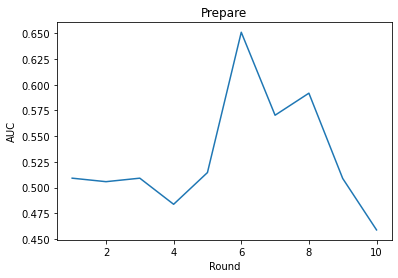

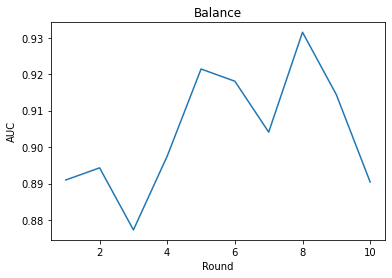

In [12]:
Kfold(X_P,y_P,"Prepare")
Kfold(X_B,y_B,"Balance")

### (f) Give a comparison between (c) and (e). Any suggestion or insight?

由(c)(e)結果可以看出 Balance dataset的正確率遠大於 Prepare(Imbalance) dataset，\
且由(d)的結果發現Prepare dataset中y label發現大約是1:14的比例，也就是說，即便不經過模型訓練，全部的y猜-1都有約9成的正確率，\
對比(c)中經過模型訓練反而正確率低很多，表示這個偏誤已經造成忽略X反而得到更高正確率，\
而在經過balance處理後，模型更能根據X去真正學習到X,y之間的預測關係，以真正根據X預測y，故達到較高的正確率(約9成)

### CART, (g), (h)
以下將prepare, balance data set各自隨機分成9:1的train, test datasets(固定random seed)\
分別跑CART, Random Forest, GBDT 三種模型，並繪出ROC圖，以比較兩種datasets 和三種模型

In [13]:
X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(X_P, y_P, test_size=0.1, random_state=100)
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.1, random_state=100)

CART

prepare


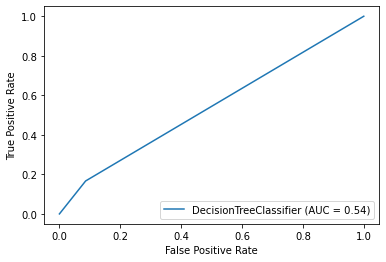

balance


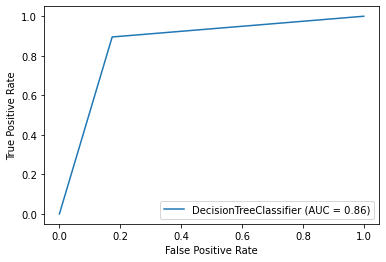

In [14]:
print("prepare")
CART_show(X_train_P, X_test_P, y_train_P, y_test_P)
print("balance")
CART_show(X_train_B, X_test_B, y_train_B, y_test_B)

### (g) Use “Random Forest” to solve both prepared dataset and balanced dataset, respectively. Give a comparison and provide your insight.

prepare


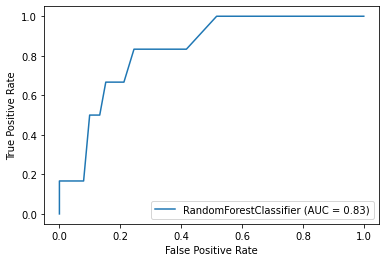

balance


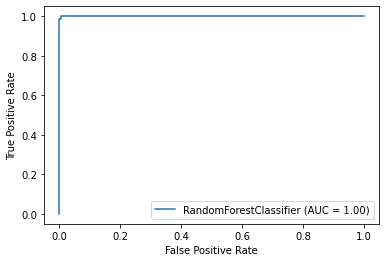

In [15]:
print("prepare")
RFC(X_train_P, X_test_P, y_train_P, y_test_P)
print("balance")
RFC(X_train_B, X_test_B, y_train_B, y_test_B)

由上面兩圖可知Balance的正確率比Prepare高

### (h) Use “Gradient Boosting Decision Tree (GBDT)” to solve both prepared dataset and balanced dataset, respectively. Give a comparison and provide your insight.

prepare


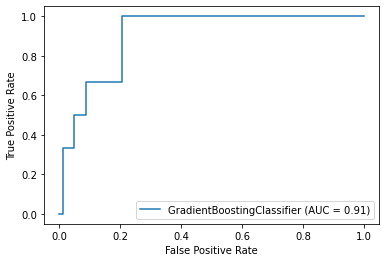

balance


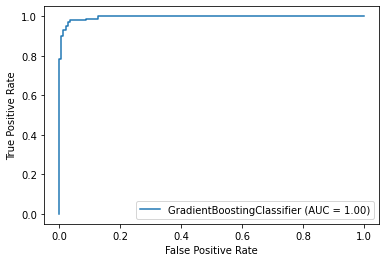

In [16]:
print("prepare")
GBDT(X_train_P, X_test_P, y_train_P, y_test_P)
print("balance")
GBDT(X_train_B, X_test_B, y_train_B, y_test_B)

由上面兩圖可知Balance的正確率比Prepare高